<a href="https://colab.research.google.com/github/Rohith616/Client-Project-1/blob/main/dart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts pyyaml==5.4.1 u8darts 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/preprocessed_data.csv', delimiter=",")
data["event"].fillna("no event", inplace=True)
data["holiday"].fillna("休日なし", inplace=True)  # replace it with no holiday
data["ds"] = pd.to_datetime(data["ds"])

In [ ]:
data

,Unnamed: 0,ds,target_id,target_address,y,event,cat_r,reg_wind,reg_r,holiday,weather,temp_max,temp_min
0,0,2015-01-01,0,東京都/東京,89.058108,no event,cat_r_1,4.4,17.856631,元日,cloud,8.2,0.7
1,1,2015-01-02,0,東京都/東京,88.638431,no event,cat_r_0,2.1,-2.435871,休日なし,sunny,7.9,-2.2
2,2,2015-01-03,0,東京都/東京,80.884749,no event,cat_r_1,3.0,15.382444,休日なし,sunny,8.9,-1.1
3,3,2015-01-04,0,東京都/東京,89.288376,no event,cat_r_0,1.3,11.864588,休日なし,cloud,9.3,-0.4
4,4,2015-01-05,0,東京都/東京,86.867064,no event,cat_r_1,2.4,-14.973754,休日なし,sunny,12.9,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3501,1748,2019-10-15,1,大阪府/大阪,156.960567,no event,cat_r_1,2.8,2.630001,休日なし,sunny,23.1,14.6
3502,1749,2019-10-16,1,大阪府/大阪,130.886110,event2,cat_r_1,2.2,23.602167,休日なし,sunny,22.4,12.8
3503,1750,2019-10-17,1,大阪府/大阪,137.061111,event2,cat_r_1,1.8,18.308426,休日なし,cloud,23.7,14.3
3504,1751,2019-10-18,1,大阪府/大阪,139.740341,no event,cat_r_1,2.5,2.687561,休日なし,cloud,24.0,18.4


In [ ]:
df = data.select_dtypes(include="object")
df = df.drop(["target_address"], axis=1)
for cols in df:
     dummies = pd.get_dummies(df[cols], drop_first=True)
     df = pd.concat([df, dummies], axis="columns")
data = pd.concat([data, df], axis="columns")
df = data.select_dtypes(include=["object"])
data = data.drop(df.columns, axis=1)

In [ ]:
data

,Unnamed: 0,ds,target_id,y,reg_wind,reg_r,temp_max,temp_min,event2,event3,no event,cat_r_1,みどりの日,休日なし,体育の日,元日,勤労感謝の日,国民の休日,天皇の即位の日,天皇誕生日,山の日,建国記念の日,憲法記念日,成人の日,振替休日,敬老の日,文化の日,春分の日,昭和の日,海の日,秋分の日,rain,snow,sunny
0,0,2015-01-01,0,89.058108,4.4,17.856631,8.2,0.7,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2015-01-02,0,88.638431,2.1,-2.435871,7.9,-2.2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,2015-01-03,0,80.884749,3.0,15.382444,8.9,-1.1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,2015-01-04,0,89.288376,1.3,11.864588,9.3,-0.4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2015-01-05,0,86.867064,2.4,-14.973754,12.9,1.3,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3501,1748,2019-10-15,1,156.960567,2.8,2.630001,23.1,14.6,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3502,1749,2019-10-16,1,130.886110,2.2,23.602167,22.4,12.8,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3503,1750,2019-10-17,1,137.061111,1.8,18.308426,23.7,14.3,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3504,1751,2019-10-18,1,139.740341,2.5,2.687561,24.0,18.4,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data1 = data

In [ ]:
data = data.groupby(data['ds'].astype(str).str.split(" ").str[0]).mean().reset_index()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
filler = MissingValuesFiller()
scaler = Scaler()
series = scaler.fit_transform(filler.transform(
    TimeSeries.from_dataframe(data, 'ds', 'y'),
  ))



In [ ]:
total_rows,total_cols= data.shape
rows= round(total_rows/5)

In [ ]:
train = data.iloc[rows:]
test = data.iloc[:rows]

In [ ]:
print(data.head())
test.shape


           ds  Unnamed: 0  target_id           y  ...  秋分の日  rain  snow  sunny
0  2015-01-01         0.0        0.5   98.105642  ...   0.0   0.0   0.0    0.5
1  2015-01-02         1.0        0.5  101.603778  ...   0.0   0.0   0.0    0.5
2  2015-01-03         2.0        0.5   89.699744  ...   0.0   0.0   0.0    1.0
3  2015-01-04         3.0        0.5   99.408296  ...   0.0   0.0   0.0    0.5
4  2015-01-05         4.0        0.5   94.491909  ...   0.0   0.0   0.0    1.0

[5 rows x 34 columns]


(351, 34)

In [ ]:
train = scaler.fit_transform(filler.transform(
    TimeSeries.from_dataframe(train, 'ds', ['y'])
))
test = scaler.fit_transform(filler.transform(
    TimeSeries.from_dataframe(test, 'ds', ['y'])
))

In [ ]:
#train, val = series.split_after(pd.Timestamp('20180101'))

In [ ]:
train

<TimeSeries (DataArray) (ds: 1402, component: 1, sample: 1)>
array([[[0.47291406]],

       [[0.38461647]],

       [[0.49889721]],

       ...,

       [[0.36923761]],

       [[0.33365764]],

       [[0.3662026 ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2015-12-18 2015-12-19 ... 2019-10-19
  * component  (component) object 'y'
Dimensions without coordinates: sample

In [ ]:
model_nbeats = NBEATSModel(input_chunk_length=24 , output_chunk_length=12,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,   
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800
)

In [ ]:
model_nbeats.fit(train,verbose=True)

[2022-02-24 03:57:24,768] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1367 samples.
[2022-02-24 03:57:24,768] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1367 samples.
[2022-02-24 03:57:24,905] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-24 03:57:24,905] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-24 03:57:24,912] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-02-24 03:57:24,912] WARNING | darts.models.forecasting.torch_forecasting_model | Depre

Training: 0it [00:00, ?it/s]

In [ ]:
test.columns

Index(['y'], dtype='object', name='component')

In [ ]:
type(test)

darts.timeseries.TimeSeries

In [ ]:
test

<TimeSeries (DataArray) (ds: 351, component: 1, sample: 1)>
array([[[0.64457373]],

       [[0.70020867]],

       [[0.51088495]],

       [[0.66529136]],

       [[0.58710033]],

       [[0.03709045]],

       [[0.48884034]],

       [[0.51332923]],

       [[0.68739432]],

       [[0.52183923]],

...

       [[0.84789806]],

       [[0.94383817]],

       [[1.        ]],

       [[0.78387401]],

       [[0.85155455]],

       [[0.56993417]],

       [[0.49266215]],

       [[0.93144097]],

       [[0.96513246]],

       [[0.89282198]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-17
  * component  (component) object 'y'
Dimensions without coordinates: sample

In [ ]:
pred_series = model_nbeats.historical_forecasts(test,
                                                  #start = 10,
                                                  forecast_horizon=7,
                                                  stride=5,
                                                  retrain=False,
                                                  last_points_only=True,
                                                  verbose=True
)

  0%|          | 0/34 [00:00<?, ?it/s]

Predicting: 2it [00:00, ?it/s]

  3%|▎         | 1/34 [00:00<00:03,  8.49it/s]

Predicting: 2it [00:00, ?it/s]

  6%|▌         | 2/34 [00:00<00:03,  8.25it/s]

Predicting: 2it [00:00, ?it/s]

  9%|▉         | 3/34 [00:00<00:04,  7.64it/s]

Predicting: 2it [00:00, ?it/s]

 12%|█▏        | 4/34 [00:00<00:04,  7.41it/s]

Predicting: 2it [00:00, ?it/s]

 15%|█▍        | 5/34 [00:00<00:04,  7.00it/s]

Predicting: 2it [00:00, ?it/s]

 18%|█▊        | 6/34 [00:00<00:03,  7.43it/s]

Predicting: 2it [00:00, ?it/s]

 21%|██        | 7/34 [00:00<00:03,  7.39it/s]

Predicting: 2it [00:00, ?it/s]

 24%|██▎       | 8/34 [00:01<00:03,  6.91it/s]

Predicting: 2it [00:00, ?it/s]

 26%|██▋       | 9/34 [00:01<00:03,  6.96it/s]

Predicting: 2it [00:00, ?it/s]

 29%|██▉       | 10/34 [00:01<00:03,  7.01it/s]

Predicting: 2it [00:00, ?it/s]

 32%|███▏      | 11/34 [00:01<00:03,  6.88it/s]

Predicting: 2it [00:00, ?it/s]

 35%|███▌      | 12/34 [00:01<00:03,  7.03it/s]

Predicting: 2it [00:00, ?it/s]

 38%|███▊      | 13/34 [00:01<00:02,  7.24it/s]

Predicting: 2it [00:00, ?it/s]

 41%|████      | 14/34 [00:01<00:02,  7.26it/s]

Predicting: 2it [00:00, ?it/s]

 44%|████▍     | 15/34 [00:02<00:02,  7.32it/s]

Predicting: 2it [00:00, ?it/s]

 47%|████▋     | 16/34 [00:02<00:02,  7.33it/s]

Predicting: 2it [00:00, ?it/s]

 50%|█████     | 17/34 [00:02<00:02,  7.29it/s]

Predicting: 2it [00:00, ?it/s]

 53%|█████▎    | 18/34 [00:02<00:02,  7.28it/s]

Predicting: 2it [00:00, ?it/s]

 56%|█████▌    | 19/34 [00:02<00:02,  7.34it/s]

Predicting: 2it [00:00, ?it/s]

 59%|█████▉    | 20/34 [00:02<00:01,  7.29it/s]

Predicting: 2it [00:00, ?it/s]

 62%|██████▏   | 21/34 [00:02<00:01,  7.27it/s]

Predicting: 2it [00:00, ?it/s]

 65%|██████▍   | 22/34 [00:03<00:01,  7.31it/s]

Predicting: 2it [00:00, ?it/s]

 68%|██████▊   | 23/34 [00:03<00:01,  7.08it/s]

Predicting: 2it [00:00, ?it/s]

 71%|███████   | 24/34 [00:03<00:01,  7.13it/s]

Predicting: 2it [00:00, ?it/s]

 74%|███████▎  | 25/34 [00:03<00:01,  7.21it/s]

Predicting: 2it [00:00, ?it/s]

 76%|███████▋  | 26/34 [00:03<00:01,  7.27it/s]

Predicting: 2it [00:00, ?it/s]

 79%|███████▉  | 27/34 [00:03<00:00,  7.23it/s]

Predicting: 2it [00:00, ?it/s]

 82%|████████▏ | 28/34 [00:03<00:00,  6.66it/s]

Predicting: 2it [00:00, ?it/s]

 85%|████████▌ | 29/34 [00:04<00:00,  7.00it/s]

Predicting: 2it [00:00, ?it/s]

 88%|████████▊ | 30/34 [00:04<00:00,  7.09it/s]

Predicting: 2it [00:00, ?it/s]

 91%|█████████ | 31/34 [00:04<00:00,  7.11it/s]

Predicting: 2it [00:00, ?it/s]

 94%|█████████▍| 32/34 [00:04<00:00,  7.02it/s]

Predicting: 2it [00:00, ?it/s]

 97%|█████████▋| 33/34 [00:04<00:00,  7.10it/s]

Predicting: 2it [00:00, ?it/s]

100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


In [ ]:
#future_data = future_data.drop("y", axis=1)

In [ ]:
print("Mape = {:.2f}%".format(mape(series , pred_series)))

Mape = 92.51%


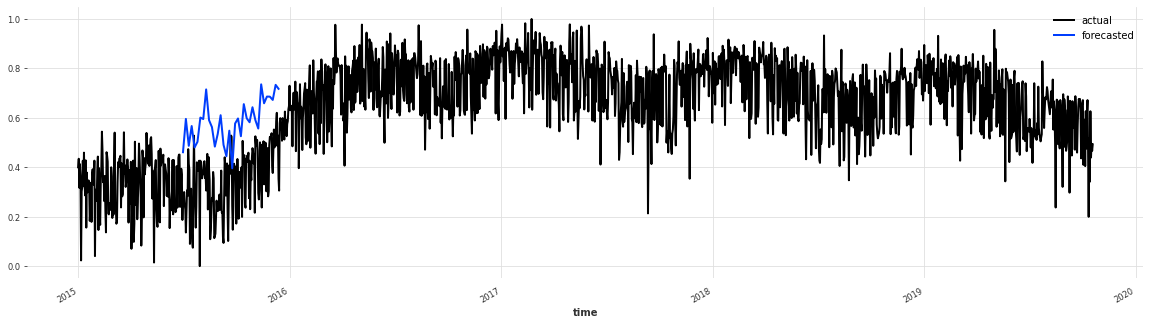

In [ ]:
fig = plt.figure(figsize=(20,5))
series .plot(label = "actual")
pred_series.plot(label = "forecasted") # validation data set
plt.legend()

In [ ]:
future_data = data1
future_data = future_data.iloc[1000:2000]

In [ ]:
future_data['target_id'].unique()

array([0, 1])

In [ ]:
for target_id, sub_data in data1.groupby("target_id"):
  sub_future_data = future_data[future_data["target_id"] == target_id]
  sub_future_data = sub_future_data.groupby(data['ds'].astype(str).str.split(" ").str[0]).mean().reset_index()
  total_rows,total_cols= data.shape
  rows= round(total_rows/5)
  train = data.iloc[rows:]
  test = data.iloc[:rows]

  train = scaler.fit_transform(filler.transform(
          TimeSeries.from_dataframe(sub_data, 'ds', ['y'])
              ))
  test = scaler.fit_transform(filler.transform(
           TimeSeries.from_dataframe(sub_data, 'ds', ['y'])
              ))
  future_data = scaler.fit_transform(filler.transform(
        TimeSeries.from_dataframe(sub_future_data, 'ds', ['y'])
              ))
  model = NBEATSModel(input_chunk_length=24 , output_chunk_length=12,
            generic_architecture=True,
            num_stacks=10,
            num_blocks=1,
            num_layers=4,
            layer_widths=512,   
            n_epochs=100,
            nr_epochs_val_period=1,
            batch_size=800
  )
  model.fit(train,verbose=True)
  future_pred = model.historical_forecasts(future_data,
                                                 forecast_horizon=7,
                                                  stride=5,
                                                  retrain=False,
                                                  last_points_only=True,
                                                  verbose=True
                                                )
  


[2022-02-24 04:58:46,016] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1718 samples.
[2022-02-24 04:58:46,016] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1718 samples.
[2022-02-24 04:58:46,096] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-24 04:58:46,096] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-24 04:58:46,100] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progress_bar_refresh_rate` and `enable_model_summary` in the `pl_trainer_kwargs` dict at model creation.
[2022-02-24 04:58:46,100] WARNING | darts.models.forecasting.torch_forecasting_model | Depre

Training: 0it [00:00, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Predicting: 3it [00:00, ?it/s]

  1%|▏         | 1/75 [00:00<00:07,  9.66it/s]

Predicting: 3it [00:00, ?it/s]

  3%|▎         | 2/75 [00:00<00:08,  8.31it/s]

Predicting: 3it [00:00, ?it/s]

  4%|▍         | 3/75 [00:00<00:09,  7.75it/s]

Predicting: 3it [00:00, ?it/s]

  5%|▌         | 4/75 [00:00<00:09,  7.11it/s]

Predicting: 3it [00:00, ?it/s]

  7%|▋         | 5/75 [00:00<00:09,  7.28it/s]

Predicting: 3it [00:00, ?it/s]

  8%|▊         | 6/75 [00:00<00:09,  7.18it/s]

Predicting: 3it [00:00, ?it/s]

  9%|▉         | 7/75 [00:00<00:09,  7.23it/s]

Predicting: 3it [00:00, ?it/s]

 11%|█         | 8/75 [00:01<00:08,  7.55it/s]

Predicting: 3it [00:00, ?it/s]

 12%|█▏        | 9/75 [00:01<00:08,  7.51it/s]

Predicting: 3it [00:00, ?it/s]

 13%|█▎        | 10/75 [00:01<00:08,  7.62it/s]

Predicting: 3it [00:00, ?it/s]

 15%|█▍        | 11/75 [00:01<00:08,  7.63it/s]

Predicting: 3it [00:00, ?it/s]

 16%|█▌        | 12/75 [00:01<00:08,  7.50it/s]

Predicting: 3it [00:00, ?it/s]

 17%|█▋        | 13/75 [00:01<00:08,  7.33it/s]

Predicting: 3it [00:00, ?it/s]

 19%|█▊        | 14/75 [00:01<00:08,  7.31it/s]

Predicting: 3it [00:00, ?it/s]

 20%|██        | 15/75 [00:02<00:08,  7.50it/s]

Predicting: 3it [00:00, ?it/s]

 21%|██▏       | 16/75 [00:02<00:07,  7.57it/s]

Predicting: 3it [00:00, ?it/s]

 23%|██▎       | 17/75 [00:02<00:08,  7.17it/s]

Predicting: 3it [00:00, ?it/s]

 24%|██▍       | 18/75 [00:02<00:07,  7.17it/s]

Predicting: 3it [00:00, ?it/s]

 25%|██▌       | 19/75 [00:02<00:07,  7.22it/s]

Predicting: 3it [00:00, ?it/s]

 27%|██▋       | 20/75 [00:02<00:07,  7.09it/s]

Predicting: 3it [00:00, ?it/s]

 28%|██▊       | 21/75 [00:02<00:07,  7.14it/s]

Predicting: 3it [00:00, ?it/s]

 29%|██▉       | 22/75 [00:02<00:07,  7.40it/s]

Predicting: 3it [00:00, ?it/s]

 31%|███       | 23/75 [00:03<00:07,  7.37it/s]

Predicting: 3it [00:00, ?it/s]

 32%|███▏      | 24/75 [00:03<00:06,  7.42it/s]

Predicting: 3it [00:00, ?it/s]

 33%|███▎      | 25/75 [00:03<00:06,  7.41it/s]

Predicting: 3it [00:00, ?it/s]

 35%|███▍      | 26/75 [00:03<00:06,  7.47it/s]

Predicting: 3it [00:00, ?it/s]

 36%|███▌      | 27/75 [00:03<00:06,  7.56it/s]

Predicting: 3it [00:00, ?it/s]

 37%|███▋      | 28/75 [00:03<00:06,  7.04it/s]

Predicting: 3it [00:00, ?it/s]

 39%|███▊      | 29/75 [00:03<00:06,  6.91it/s]

Predicting: 3it [00:00, ?it/s]

 40%|████      | 30/75 [00:04<00:06,  7.20it/s]

Predicting: 3it [00:00, ?it/s]

 41%|████▏     | 31/75 [00:04<00:05,  7.41it/s]

Predicting: 3it [00:00, ?it/s]

 43%|████▎     | 32/75 [00:04<00:06,  6.95it/s]

Predicting: 3it [00:00, ?it/s]

 44%|████▍     | 33/75 [00:04<00:05,  7.44it/s]

Predicting: 3it [00:00, ?it/s]

 45%|████▌     | 34/75 [00:04<00:05,  7.26it/s]

Predicting: 3it [00:00, ?it/s]

 47%|████▋     | 35/75 [00:04<00:05,  6.99it/s]

Predicting: 3it [00:00, ?it/s]

 48%|████▊     | 36/75 [00:04<00:05,  6.69it/s]

Predicting: 3it [00:00, ?it/s]

 49%|████▉     | 37/75 [00:05<00:05,  6.55it/s]

Predicting: 3it [00:00, ?it/s]

 51%|█████     | 38/75 [00:05<00:05,  6.88it/s]

Predicting: 3it [00:00, ?it/s]

 52%|█████▏    | 39/75 [00:05<00:05,  6.82it/s]

Predicting: 3it [00:00, ?it/s]

 53%|█████▎    | 40/75 [00:05<00:05,  6.94it/s]

Predicting: 3it [00:00, ?it/s]

 55%|█████▍    | 41/75 [00:05<00:04,  6.86it/s]

Predicting: 3it [00:00, ?it/s]

 56%|█████▌    | 42/75 [00:05<00:04,  6.96it/s]

Predicting: 3it [00:00, ?it/s]

 57%|█████▋    | 43/75 [00:05<00:04,  6.94it/s]

Predicting: 3it [00:00, ?it/s]

 59%|█████▊    | 44/75 [00:06<00:04,  7.05it/s]

Predicting: 3it [00:00, ?it/s]

 60%|██████    | 45/75 [00:06<00:04,  7.11it/s]

Predicting: 3it [00:00, ?it/s]

 61%|██████▏   | 46/75 [00:06<00:04,  7.16it/s]

Predicting: 3it [00:00, ?it/s]

 63%|██████▎   | 47/75 [00:06<00:03,  7.32it/s]

Predicting: 3it [00:00, ?it/s]

 64%|██████▍   | 48/75 [00:06<00:03,  7.34it/s]

Predicting: 3it [00:00, ?it/s]

 65%|██████▌   | 49/75 [00:06<00:03,  7.39it/s]

Predicting: 3it [00:00, ?it/s]

 67%|██████▋   | 50/75 [00:06<00:03,  6.92it/s]

Predicting: 3it [00:00, ?it/s]

 68%|██████▊   | 51/75 [00:07<00:03,  6.89it/s]

Predicting: 3it [00:00, ?it/s]

 69%|██████▉   | 52/75 [00:07<00:03,  6.85it/s]

Predicting: 3it [00:00, ?it/s]

 71%|███████   | 53/75 [00:07<00:03,  6.75it/s]

Predicting: 3it [00:00, ?it/s]

 72%|███████▏  | 54/75 [00:07<00:03,  6.87it/s]

Predicting: 3it [00:00, ?it/s]

 73%|███████▎  | 55/75 [00:07<00:02,  7.05it/s]

Predicting: 3it [00:00, ?it/s]

 75%|███████▍  | 56/75 [00:07<00:02,  7.12it/s]

Predicting: 3it [00:00, ?it/s]

 76%|███████▌  | 57/75 [00:07<00:02,  7.14it/s]

Predicting: 3it [00:00, ?it/s]

 77%|███████▋  | 58/75 [00:08<00:02,  7.08it/s]

Predicting: 3it [00:00, ?it/s]

 79%|███████▊  | 59/75 [00:08<00:02,  6.96it/s]

Predicting: 3it [00:00, ?it/s]

 80%|████████  | 60/75 [00:08<00:02,  6.94it/s]

Predicting: 3it [00:00, ?it/s]

 81%|████████▏ | 61/75 [00:08<00:02,  6.84it/s]

Predicting: 3it [00:00, ?it/s]

 83%|████████▎ | 62/75 [00:08<00:01,  6.92it/s]

Predicting: 3it [00:00, ?it/s]

 84%|████████▍ | 63/75 [00:08<00:01,  6.40it/s]

Predicting: 3it [00:00, ?it/s]

 85%|████████▌ | 64/75 [00:08<00:01,  6.51it/s]

Predicting: 3it [00:00, ?it/s]

 87%|████████▋ | 65/75 [00:09<00:01,  6.47it/s]

Predicting: 3it [00:00, ?it/s]

 88%|████████▊ | 66/75 [00:09<00:01,  6.37it/s]

Predicting: 3it [00:00, ?it/s]

 89%|████████▉ | 67/75 [00:09<00:01,  6.48it/s]

Predicting: 3it [00:00, ?it/s]

 91%|█████████ | 68/75 [00:09<00:01,  6.22it/s]

Predicting: 3it [00:00, ?it/s]

 92%|█████████▏| 69/75 [00:09<00:00,  6.23it/s]

Predicting: 3it [00:00, ?it/s]

 93%|█████████▎| 70/75 [00:09<00:00,  6.03it/s]

Predicting: 3it [00:00, ?it/s]

 95%|█████████▍| 71/75 [00:10<00:00,  6.12it/s]

Predicting: 3it [00:00, ?it/s]

 96%|█████████▌| 72/75 [00:10<00:00,  6.12it/s]

Predicting: 3it [00:00, ?it/s]

 97%|█████████▋| 73/75 [00:10<00:00,  6.28it/s]

Predicting: 3it [00:00, ?it/s]

 99%|█████████▊| 74/75 [00:10<00:00,  6.22it/s]

Predicting: 3it [00:00, ?it/s]

100%|██████████| 75/75 [00:10<00:00,  6.98it/s]


KeyError: ignored

In [ ]:
pred = model.historical_forecasts(test,
                                                 forecast_horizon=7,
                                                  stride=5,
                                                  retrain=False,
                                                  last_points_only=True,
                                                  verbose=True
  )

  0%|          | 0/175 [00:00<?, ?it/s]

Predicting: 3it [00:00, ?it/s]

  1%|          | 1/175 [00:00<00:19,  9.06it/s]

Predicting: 3it [00:00, ?it/s]

  1%|          | 2/175 [00:00<00:22,  7.79it/s]

Predicting: 3it [00:00, ?it/s]

  2%|▏         | 3/175 [00:00<00:22,  7.55it/s]

Predicting: 3it [00:00, ?it/s]

  2%|▏         | 4/175 [00:00<00:20,  8.21it/s]

Predicting: 3it [00:00, ?it/s]

  3%|▎         | 5/175 [00:00<00:24,  6.83it/s]

Predicting: 3it [00:00, ?it/s]

  3%|▎         | 6/175 [00:00<00:24,  7.04it/s]

Predicting: 3it [00:00, ?it/s]

  4%|▍         | 7/175 [00:00<00:23,  7.22it/s]

Predicting: 3it [00:00, ?it/s]

  5%|▍         | 8/175 [00:01<00:22,  7.40it/s]

Predicting: 3it [00:00, ?it/s]

  5%|▌         | 9/175 [00:01<00:22,  7.36it/s]

Predicting: 3it [00:00, ?it/s]

  6%|▌         | 10/175 [00:01<00:21,  7.55it/s]

Predicting: 3it [00:00, ?it/s]

  6%|▋         | 11/175 [00:01<00:21,  7.50it/s]

Predicting: 3it [00:00, ?it/s]

  7%|▋         | 12/175 [00:01<00:21,  7.60it/s]

Predicting: 3it [00:00, ?it/s]

  7%|▋         | 13/175 [00:01<00:22,  7.32it/s]

Predicting: 3it [00:00, ?it/s]

  8%|▊         | 14/175 [00:01<00:22,  7.19it/s]

Predicting: 3it [00:00, ?it/s]

  9%|▊         | 15/175 [00:02<00:21,  7.35it/s]

Predicting: 3it [00:00, ?it/s]

  9%|▉         | 16/175 [00:02<00:21,  7.30it/s]

Predicting: 3it [00:00, ?it/s]

 10%|▉         | 17/175 [00:02<00:21,  7.44it/s]

Predicting: 3it [00:00, ?it/s]

 10%|█         | 18/175 [00:02<00:21,  7.44it/s]

Predicting: 3it [00:00, ?it/s]

 11%|█         | 19/175 [00:02<00:20,  7.52it/s]

Predicting: 3it [00:00, ?it/s]

 11%|█▏        | 20/175 [00:02<00:21,  7.35it/s]

Predicting: 3it [00:00, ?it/s]

 12%|█▏        | 21/175 [00:02<00:20,  7.35it/s]

Predicting: 3it [00:00, ?it/s]

 13%|█▎        | 22/175 [00:02<00:20,  7.33it/s]

Predicting: 3it [00:00, ?it/s]

 13%|█▎        | 23/175 [00:03<00:20,  7.34it/s]

Predicting: 3it [00:00, ?it/s]

 14%|█▎        | 24/175 [00:03<00:20,  7.19it/s]

Predicting: 3it [00:00, ?it/s]

 14%|█▍        | 25/175 [00:03<00:20,  7.34it/s]

Predicting: 3it [00:00, ?it/s]

 15%|█▍        | 26/175 [00:03<00:20,  7.21it/s]

Predicting: 3it [00:00, ?it/s]

 15%|█▌        | 27/175 [00:03<00:20,  7.13it/s]

Predicting: 3it [00:00, ?it/s]

 16%|█▌        | 28/175 [00:03<00:20,  7.02it/s]

Predicting: 3it [00:00, ?it/s]

 17%|█▋        | 29/175 [00:03<00:20,  7.12it/s]

Predicting: 3it [00:00, ?it/s]

 17%|█▋        | 30/175 [00:04<00:20,  7.22it/s]

Predicting: 3it [00:00, ?it/s]

 18%|█▊        | 31/175 [00:04<00:20,  7.00it/s]

Predicting: 3it [00:00, ?it/s]

 18%|█▊        | 32/175 [00:04<00:20,  6.84it/s]

Predicting: 3it [00:00, ?it/s]

 19%|█▉        | 33/175 [00:04<00:20,  7.03it/s]

Predicting: 3it [00:00, ?it/s]

 19%|█▉        | 34/175 [00:04<00:20,  6.73it/s]

Predicting: 3it [00:00, ?it/s]

 20%|██        | 35/175 [00:04<00:22,  6.36it/s]

Predicting: 3it [00:00, ?it/s]

 21%|██        | 36/175 [00:05<00:20,  6.66it/s]

Predicting: 3it [00:00, ?it/s]

 21%|██        | 37/175 [00:05<00:20,  6.79it/s]

Predicting: 3it [00:00, ?it/s]

 22%|██▏       | 38/175 [00:05<00:19,  6.94it/s]

Predicting: 3it [00:00, ?it/s]

 22%|██▏       | 39/175 [00:05<00:19,  7.01it/s]

Predicting: 3it [00:00, ?it/s]

 23%|██▎       | 40/175 [00:05<00:19,  7.03it/s]

Predicting: 3it [00:00, ?it/s]

 23%|██▎       | 41/175 [00:05<00:19,  6.83it/s]

Predicting: 3it [00:00, ?it/s]

 24%|██▍       | 42/175 [00:05<00:18,  7.04it/s]

Predicting: 3it [00:00, ?it/s]

 25%|██▍       | 43/175 [00:05<00:18,  7.03it/s]

Predicting: 3it [00:00, ?it/s]

 25%|██▌       | 44/175 [00:06<00:18,  6.91it/s]

Predicting: 3it [00:00, ?it/s]

 26%|██▌       | 45/175 [00:06<00:18,  6.96it/s]

Predicting: 3it [00:00, ?it/s]

 26%|██▋       | 46/175 [00:06<00:18,  6.96it/s]

Predicting: 3it [00:00, ?it/s]

 27%|██▋       | 47/175 [00:06<00:18,  7.11it/s]

Predicting: 3it [00:00, ?it/s]

 27%|██▋       | 48/175 [00:06<00:18,  6.88it/s]

Predicting: 3it [00:00, ?it/s]

 28%|██▊       | 49/175 [00:06<00:18,  6.77it/s]

Predicting: 3it [00:00, ?it/s]

 29%|██▊       | 50/175 [00:07<00:19,  6.55it/s]

Predicting: 3it [00:00, ?it/s]

 29%|██▉       | 51/175 [00:07<00:17,  7.01it/s]

Predicting: 3it [00:00, ?it/s]

 30%|██▉       | 52/175 [00:07<00:17,  7.00it/s]

Predicting: 3it [00:00, ?it/s]

 30%|███       | 53/175 [00:07<00:17,  6.95it/s]

Predicting: 3it [00:00, ?it/s]

 31%|███       | 54/175 [00:07<00:17,  7.05it/s]

Predicting: 3it [00:00, ?it/s]

 31%|███▏      | 55/175 [00:07<00:16,  7.19it/s]

Predicting: 3it [00:00, ?it/s]

 32%|███▏      | 56/175 [00:07<00:16,  7.20it/s]

Predicting: 3it [00:00, ?it/s]

 33%|███▎      | 57/175 [00:07<00:16,  7.29it/s]

Predicting: 3it [00:00, ?it/s]

 33%|███▎      | 58/175 [00:08<00:15,  7.31it/s]

Predicting: 3it [00:00, ?it/s]

 34%|███▎      | 59/175 [00:08<00:15,  7.35it/s]

Predicting: 3it [00:00, ?it/s]

 34%|███▍      | 60/175 [00:08<00:15,  7.40it/s]

Predicting: 3it [00:00, ?it/s]

 35%|███▍      | 61/175 [00:08<00:15,  7.46it/s]

Predicting: 3it [00:00, ?it/s]

 35%|███▌      | 62/175 [00:08<00:15,  7.52it/s]

Predicting: 3it [00:00, ?it/s]

 36%|███▌      | 63/175 [00:08<00:15,  7.45it/s]

Predicting: 3it [00:00, ?it/s]

 37%|███▋      | 64/175 [00:08<00:14,  7.45it/s]

Predicting: 3it [00:00, ?it/s]

 37%|███▋      | 65/175 [00:09<00:15,  7.31it/s]

Predicting: 3it [00:00, ?it/s]

 38%|███▊      | 66/175 [00:09<00:14,  7.32it/s]

Predicting: 3it [00:00, ?it/s]

 38%|███▊      | 67/175 [00:09<00:14,  7.43it/s]

Predicting: 3it [00:00, ?it/s]

 39%|███▉      | 68/175 [00:09<00:14,  7.52it/s]

Predicting: 3it [00:00, ?it/s]

 39%|███▉      | 69/175 [00:09<00:13,  7.60it/s]

Predicting: 3it [00:00, ?it/s]

 40%|████      | 70/175 [00:09<00:13,  7.55it/s]

Predicting: 3it [00:00, ?it/s]

 41%|████      | 71/175 [00:09<00:13,  7.62it/s]

Predicting: 3it [00:00, ?it/s]

 41%|████      | 72/175 [00:10<00:14,  7.24it/s]

Predicting: 3it [00:00, ?it/s]

 42%|████▏     | 73/175 [00:10<00:14,  6.84it/s]

Predicting: 3it [00:00, ?it/s]

 42%|████▏     | 74/175 [00:10<00:14,  6.84it/s]

Predicting: 3it [00:00, ?it/s]

 43%|████▎     | 75/175 [00:10<00:14,  6.80it/s]

Predicting: 3it [00:00, ?it/s]

 43%|████▎     | 76/175 [00:10<00:14,  6.67it/s]

Predicting: 3it [00:00, ?it/s]

 44%|████▍     | 77/175 [00:10<00:14,  6.54it/s]

Predicting: 3it [00:00, ?it/s]

 45%|████▍     | 78/175 [00:10<00:15,  6.34it/s]

Predicting: 3it [00:00, ?it/s]

 45%|████▌     | 79/175 [00:11<00:15,  6.27it/s]

Predicting: 3it [00:00, ?it/s]

 46%|████▌     | 80/175 [00:11<00:15,  6.11it/s]

Predicting: 3it [00:00, ?it/s]

 46%|████▋     | 81/175 [00:11<00:15,  6.21it/s]

Predicting: 3it [00:00, ?it/s]

 47%|████▋     | 82/175 [00:11<00:14,  6.42it/s]

Predicting: 3it [00:00, ?it/s]

 47%|████▋     | 83/175 [00:11<00:14,  6.56it/s]

Predicting: 3it [00:00, ?it/s]

 48%|████▊     | 84/175 [00:11<00:14,  6.39it/s]

Predicting: 3it [00:00, ?it/s]

 49%|████▊     | 85/175 [00:12<00:13,  6.49it/s]

Predicting: 3it [00:00, ?it/s]

 49%|████▉     | 86/175 [00:12<00:14,  6.35it/s]

Predicting: 3it [00:00, ?it/s]

 50%|████▉     | 87/175 [00:12<00:13,  6.29it/s]

Predicting: 3it [00:00, ?it/s]

 50%|█████     | 88/175 [00:12<00:14,  6.21it/s]

Predicting: 3it [00:00, ?it/s]

 51%|█████     | 89/175 [00:12<00:14,  6.01it/s]

Predicting: 3it [00:00, ?it/s]

 51%|█████▏    | 90/175 [00:12<00:13,  6.37it/s]

Predicting: 3it [00:00, ?it/s]

 52%|█████▏    | 91/175 [00:12<00:12,  6.63it/s]

Predicting: 3it [00:00, ?it/s]

 53%|█████▎    | 92/175 [00:13<00:12,  6.80it/s]

Predicting: 3it [00:00, ?it/s]

 53%|█████▎    | 93/175 [00:13<00:11,  6.98it/s]

Predicting: 3it [00:00, ?it/s]

 54%|█████▎    | 94/175 [00:13<00:11,  6.98it/s]

Predicting: 3it [00:00, ?it/s]

 54%|█████▍    | 95/175 [00:13<00:11,  7.12it/s]

Predicting: 3it [00:00, ?it/s]

 55%|█████▍    | 96/175 [00:13<00:11,  7.12it/s]

Predicting: 3it [00:00, ?it/s]

 55%|█████▌    | 97/175 [00:13<00:12,  6.48it/s]

Predicting: 3it [00:00, ?it/s]

 56%|█████▌    | 98/175 [00:14<00:11,  6.68it/s]

Predicting: 3it [00:00, ?it/s]

 57%|█████▋    | 99/175 [00:14<00:10,  6.94it/s]

Predicting: 3it [00:00, ?it/s]

 57%|█████▋    | 100/175 [00:14<00:10,  7.08it/s]

Predicting: 3it [00:00, ?it/s]

 58%|█████▊    | 101/175 [00:14<00:11,  6.55it/s]

Predicting: 3it [00:00, ?it/s]

 58%|█████▊    | 102/175 [00:14<00:11,  6.30it/s]

Predicting: 3it [00:00, ?it/s]

 59%|█████▉    | 103/175 [00:14<00:12,  5.98it/s]

Predicting: 3it [00:00, ?it/s]

 59%|█████▉    | 104/175 [00:14<00:11,  6.13it/s]

Predicting: 3it [00:00, ?it/s]

 60%|██████    | 105/175 [00:15<00:11,  6.11it/s]

Predicting: 3it [00:00, ?it/s]

 61%|██████    | 106/175 [00:15<00:10,  6.46it/s]

Predicting: 3it [00:00, ?it/s]

 61%|██████    | 107/175 [00:15<00:10,  6.55it/s]

Predicting: 3it [00:00, ?it/s]

 62%|██████▏   | 108/175 [00:15<00:09,  6.84it/s]

Predicting: 3it [00:00, ?it/s]

 62%|██████▏   | 109/175 [00:15<00:09,  7.04it/s]

Predicting: 3it [00:00, ?it/s]

 63%|██████▎   | 110/175 [00:15<00:09,  6.81it/s]

Predicting: 3it [00:00, ?it/s]

 63%|██████▎   | 111/175 [00:15<00:09,  6.58it/s]

Predicting: 3it [00:00, ?it/s]

 64%|██████▍   | 112/175 [00:16<00:09,  6.78it/s]

Predicting: 3it [00:00, ?it/s]

 65%|██████▍   | 113/175 [00:16<00:08,  6.96it/s]

Predicting: 3it [00:00, ?it/s]

 65%|██████▌   | 114/175 [00:16<00:09,  6.78it/s]

Predicting: 3it [00:00, ?it/s]

 66%|██████▌   | 115/175 [00:16<00:08,  6.84it/s]

Predicting: 3it [00:00, ?it/s]

 66%|██████▋   | 116/175 [00:16<00:09,  6.53it/s]

Predicting: 3it [00:00, ?it/s]

 67%|██████▋   | 117/175 [00:16<00:09,  6.39it/s]

Predicting: 3it [00:00, ?it/s]

 67%|██████▋   | 118/175 [00:17<00:08,  6.34it/s]

Predicting: 3it [00:00, ?it/s]

 68%|██████▊   | 119/175 [00:17<00:08,  6.49it/s]

Predicting: 3it [00:00, ?it/s]

 69%|██████▊   | 120/175 [00:17<00:08,  6.63it/s]

Predicting: 3it [00:00, ?it/s]

 69%|██████▉   | 121/175 [00:17<00:07,  6.79it/s]

Predicting: 3it [00:00, ?it/s]

 70%|██████▉   | 122/175 [00:17<00:07,  6.63it/s]

Predicting: 3it [00:00, ?it/s]

 70%|███████   | 123/175 [00:17<00:08,  6.00it/s]

Predicting: 3it [00:00, ?it/s]

 71%|███████   | 124/175 [00:18<00:08,  6.07it/s]

Predicting: 3it [00:00, ?it/s]

 71%|███████▏  | 125/175 [00:18<00:08,  6.17it/s]

Predicting: 3it [00:00, ?it/s]

 72%|███████▏  | 126/175 [00:18<00:08,  5.88it/s]

Predicting: 3it [00:00, ?it/s]

 73%|███████▎  | 127/175 [00:18<00:07,  6.17it/s]

Predicting: 3it [00:00, ?it/s]

 73%|███████▎  | 128/175 [00:18<00:07,  6.26it/s]

Predicting: 3it [00:00, ?it/s]

 74%|███████▎  | 129/175 [00:18<00:07,  6.41it/s]

Predicting: 3it [00:00, ?it/s]

 74%|███████▍  | 130/175 [00:18<00:06,  6.69it/s]

Predicting: 3it [00:00, ?it/s]

 75%|███████▍  | 131/175 [00:19<00:06,  6.91it/s]

Predicting: 3it [00:00, ?it/s]

 75%|███████▌  | 132/175 [00:19<00:06,  6.74it/s]

Predicting: 3it [00:00, ?it/s]

 76%|███████▌  | 133/175 [00:19<00:06,  6.60it/s]

Predicting: 3it [00:00, ?it/s]

 77%|███████▋  | 134/175 [00:19<00:06,  6.74it/s]

Predicting: 3it [00:00, ?it/s]

 77%|███████▋  | 135/175 [00:19<00:05,  6.87it/s]

Predicting: 3it [00:00, ?it/s]

 78%|███████▊  | 136/175 [00:19<00:05,  6.88it/s]

Predicting: 3it [00:00, ?it/s]

 78%|███████▊  | 137/175 [00:19<00:05,  6.66it/s]

Predicting: 3it [00:00, ?it/s]

 79%|███████▉  | 138/175 [00:20<00:06,  6.11it/s]

Predicting: 3it [00:00, ?it/s]

 79%|███████▉  | 139/175 [00:20<00:05,  6.37it/s]

Predicting: 3it [00:00, ?it/s]

 80%|████████  | 140/175 [00:20<00:05,  6.69it/s]

Predicting: 3it [00:00, ?it/s]

 81%|████████  | 141/175 [00:21<00:10,  3.31it/s]

Predicting: 3it [00:00, ?it/s]

 81%|████████  | 142/175 [00:21<00:09,  3.63it/s]

Predicting: 3it [00:00, ?it/s]

 82%|████████▏ | 143/175 [00:21<00:08,  3.92it/s]

Predicting: 3it [00:00, ?it/s]

 82%|████████▏ | 144/175 [00:21<00:09,  3.15it/s]

Predicting: 3it [00:00, ?it/s]

 83%|████████▎ | 145/175 [00:22<00:10,  2.74it/s]

Predicting: 3it [00:00, ?it/s]

 83%|████████▎ | 146/175 [00:22<00:09,  2.93it/s]

Predicting: 3it [00:00, ?it/s]

 84%|████████▍ | 147/175 [00:23<00:10,  2.56it/s]

Predicting: 3it [00:00, ?it/s]

 85%|████████▍ | 148/175 [00:23<00:10,  2.49it/s]

Predicting: 3it [00:00, ?it/s]

 85%|████████▌ | 149/175 [00:24<00:09,  2.63it/s]

Predicting: 3it [00:00, ?it/s]

 86%|████████▌ | 150/175 [00:24<00:09,  2.55it/s]

Predicting: 3it [00:00, ?it/s]

 86%|████████▋ | 151/175 [00:24<00:10,  2.31it/s]

Predicting: 3it [00:00, ?it/s]

 87%|████████▋ | 152/175 [00:25<00:09,  2.37it/s]

Predicting: 3it [00:00, ?it/s]

 87%|████████▋ | 153/175 [00:25<00:09,  2.35it/s]

Predicting: 3it [00:00, ?it/s]

 88%|████████▊ | 154/175 [00:26<00:08,  2.48it/s]

Predicting: 3it [00:00, ?it/s]

 89%|████████▊ | 155/175 [00:26<00:07,  2.64it/s]

Predicting: 3it [00:00, ?it/s]

 89%|████████▉ | 156/175 [00:27<00:09,  2.05it/s]

Predicting: 3it [00:00, ?it/s]

 90%|████████▉ | 157/175 [00:27<00:09,  1.83it/s]

Predicting: 3it [00:00, ?it/s]

 90%|█████████ | 158/175 [00:28<00:09,  1.79it/s]

Predicting: 3it [00:00, ?it/s]

 91%|█████████ | 159/175 [00:29<00:09,  1.77it/s]

Predicting: 3it [00:00, ?it/s]

 91%|█████████▏| 160/175 [00:29<00:08,  1.71it/s]

Predicting: 3it [00:00, ?it/s]

 92%|█████████▏| 161/175 [00:30<00:07,  1.91it/s]

Predicting: 3it [00:00, ?it/s]

 93%|█████████▎| 162/175 [00:30<00:05,  2.30it/s]

Predicting: 3it [00:00, ?it/s]

 93%|█████████▎| 163/175 [00:30<00:04,  2.52it/s]

Predicting: 3it [00:00, ?it/s]

 94%|█████████▎| 164/175 [00:30<00:04,  2.75it/s]

Predicting: 3it [00:00, ?it/s]

 94%|█████████▍| 165/175 [00:31<00:03,  3.14it/s]

Predicting: 3it [00:00, ?it/s]

 95%|█████████▍| 166/175 [00:31<00:02,  3.05it/s]

Predicting: 3it [00:00, ?it/s]

 95%|█████████▌| 167/175 [00:31<00:02,  2.94it/s]

Predicting: 3it [00:00, ?it/s]

 96%|█████████▌| 168/175 [00:32<00:02,  3.32it/s]

Predicting: 3it [00:00, ?it/s]

 97%|█████████▋| 169/175 [00:32<00:01,  3.17it/s]

Predicting: 3it [00:00, ?it/s]

 97%|█████████▋| 170/175 [00:32<00:01,  3.61it/s]

Predicting: 3it [00:00, ?it/s]

 98%|█████████▊| 171/175 [00:32<00:01,  3.55it/s]

Predicting: 3it [00:00, ?it/s]

 98%|█████████▊| 172/175 [00:33<00:00,  3.53it/s]

Predicting: 3it [00:00, ?it/s]

 99%|█████████▉| 173/175 [00:33<00:00,  3.56it/s]

Predicting: 3it [00:00, ?it/s]

 99%|█████████▉| 174/175 [00:33<00:00,  3.79it/s]

Predicting: 3it [00:00, ?it/s]

100%|██████████| 175/175 [00:33<00:00,  5.16it/s]
